In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import os
import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
import itertools
from models import AlexNet, LeNet

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
model = LeNet(img_width=256, img_height=256, img_depth=1, activation='relu')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model.model.load_weights('weights/new_approach-lenet-rmsprop-5-relu.h5')

/home/indtusuario/anaconda3/envs/tcc/lib/python3.7/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [6]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)
rmsprop = RMSprop(lr=1e-4)
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=True)

In [7]:
model.model.compile(loss='binary_crossentropy',
    optimizer=rmsprop,
    metrics=['acc'])

In [8]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 252, 252, 6)       156       
_________________________________________________________________
activation_1 (Activation)    (None, 252, 252, 6)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 6)       24        
_________________________________________________________________
conv_2 (Conv2D)              (None, 122, 122, 16)      2416      
_________________________________________________________________
activation_2 (Activation)    (None, 122, 122, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 16)        0         
__________

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_path = '../data/new_approach/test/'

In [10]:
test_generator = test_datagen.flow_from_directory(test_path,
                                                  class_mode=None,
                                                 color_mode='grayscale',
                                                  batch_size=1,
                                                 shuffle=False,
                                                 seed=42)

Found 8376 images belonging to 2 classes.


In [11]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

In [12]:
results = model.model.predict_generator(test_generator,
                                        steps=STEP_SIZE_TEST,
                                       verbose=1)

8376/8376 [==============================] - 98s 12ms/step


In [13]:
results

array([[2.7970200e-08],
       [2.2344910e-09],
       [2.4832604e-08],
       ...,
       [9.9996591e-01],
       [9.9947196e-01],
       [9.9993527e-01]], dtype=float32)

In [36]:
y_pred = results.copy()
y_pred = [1 if i >= 0.5 else 0 for i in results]

In [14]:
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [38]:
print("Acurácia: ", accuracy_score(y_true, y_pred))
print("F-score: ", f1_score(y_true, y_pred))

Acurácia:  0.9865090735434575
F-score:  0.9754721076622531


In [39]:
confusion_matrix(y_true, y_pred)

array([[6016,  103],
       [  10, 2247]])

In [40]:
confusion_matrix(y_true, y_pred)

array([[6016,  103],
       [  10, 2247]])

In [56]:
fpr, tpr, threshold = roc_curve(y_true, results, pos_label=1)
roc_auc = auc(fpr, tpr)

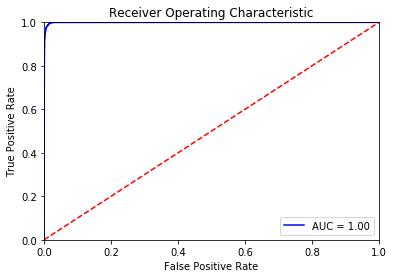

In [43]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [67]:
eer = brentq(lambda x : 1. - x - interp1d(fpr,tpr)(x), 0., 1.)
thresh = interp1d(fpr, threshold)(eer)

In [68]:
eer*100

1.1678678520700716

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13633
           1       0.00      0.00      0.00         0

    accuracy                           1.00     13633
   macro avg       0.50      0.50      0.50     13633
weighted avg       1.00      1.00      1.00     13633



/home/indtusuario/anaconda3/envs/tcc/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [21]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k, v in labels.items())
predictions = [labels[k] for k in y_pred]

In [22]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})
results.to_csv("results_2.csv", index=False)

## Testes individuais

In [24]:
from keras.preprocessing import image

In [78]:
test_image= image.load_img('data/approach2/test/forgerie/024-013-07-02.png', color_mode='grayscale') 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image/255.

In [79]:
result = model.predict(test_image)

In [80]:
result

array([[0.51207256]], dtype=float32)

## Cálculo do EER

In [50]:
results

array([[2.7970200e-08],
       [2.2344910e-09],
       [2.4832604e-08],
       ...,
       [9.9996591e-01],
       [9.9947196e-01],
       [9.9993527e-01]], dtype=float32)

In [51]:
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [54]:
threshold = np.linspace(0,1,num=100)

In [55]:
len(y_true)

8376

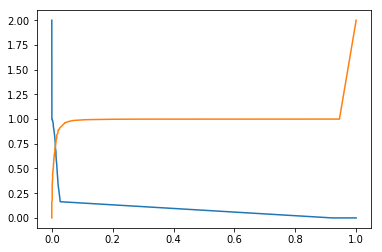

In [76]:
plt.plot(fpr, threshold)
plt.plot(1-tpr, threshold)

In [87]:
fpr, tpr, threshold = roc_curve(y_true, results, pos_label=1)
fnr = 1 - tpr
eer = brentq(lambda x : 1. - x - interp1d(fpr,tpr)(x), 0., 1., full_output=True)

In [89]:
eer

(0.011678678520700717,       converged: True
            flag: 'converged'
  function_calls: 14
      iterations: 13
            root: 0.011678678520700717)

In [77]:
threshold

array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, 9.9999976e-01,
       9.9999964e-01, 9.9999952e-01, 9.9999940e-01, 9.9999928e-01,
       9.9999905e-01, 9.9999893e-01, 9.9999881e-01, 9.9999869e-01,
       9.9999857e-01, 9.9999845e-01, 9.9999833e-01, 9.9999821e-01,
       9.9999809e-01, 9.9999797e-01, 9.9999785e-01, 9.9999774e-01,
       9.9999762e-01, 9.9999750e-01, 9.9999738e-01, 9.9999726e-01,
       9.9999714e-01, 9.9999702e-01, 9.9999690e-01, 9.9999678e-01,
       9.9999666e-01, 9.9999642e-01, 9.9999630e-01, 9.9999619e-01,
       9.9999607e-01, 9.9999595e-01, 9.9999571e-01, 9.9999559e-01,
       9.9999547e-01, 9.9999535e-01, 9.9999523e-01, 9.9999499e-01,
       9.9999487e-01, 9.9999475e-01, 9.9999464e-01, 9.9999452e-01,
       9.9999440e-01, 9.9999428e-01, 9.9999416e-01, 9.9999404e-01,
       9.9999392e-01, 9.9999380e-01, 9.9999368e-01, 9.9999356e-01,
       9.9999332e-01, 9.9999321e-01, 9.9999309e-01, 9.9999297e-01,
       9.9999285e-01, 9.9999273e-01, 9.9999261e-01, 9.9999249e

In [86]:
1. - 0.3 - interp1d(fpr,tpr)(0.3)

-0.30000000000000004

In [91]:
def f(x):
   return(1. - x - interp1d(fpr,tpr)(x))

In [92]:
brentq(f, 0., 1.)

0.011678678520700717

In [93]:
f(0.0116)

0.00022088317826018944

In [102]:
f = interp1d(fpr,tpr)

In [21]:
gscore = []
fscore = []

for i in range(len(y_true)):
    if(y_true[i] == 0):
        fscore.append(results.item(i))
    else:
        gscore.append(results.item(i))
        
print(gscore)
print(fscore)

[0.3638294041156769, 0.9998470544815063, 0.9965818524360657, 0.9994246959686279, 0.9914473295211792, 0.9715498089790344, 1.0, 0.999943733215332, 1.0, 0.9999997615814209, 0.9998217225074768, 0.9999998807907104, 0.9999239444732666, 0.9999920129776001, 0.9999735355377197, 0.9999998807907104, 1.0, 0.9661316275596619, 0.9999994039535522, 0.9999998807907104, 0.9970018267631531, 0.9998408555984497, 0.9999240636825562, 0.9999943971633911, 0.9908314347267151, 0.9983068704605103, 0.9979814291000366, 0.9985272884368896, 0.9992376565933228, 0.9999991655349731, 0.9999998807907104, 0.9999805688858032, 0.9999817609786987, 0.9721645712852478, 0.9941148161888123, 0.9935011267662048, 1.0, 1.0, 0.9999997615814209, 1.0, 0.9999958276748657, 0.9999767541885376, 0.9999992847442627, 0.999998927116394, 0.9999991655349731, 0.9997952580451965, 0.9999998807907104, 0.9999722242355347, 1.0, 1.0, 1.0, 0.9999972581863403, 0.9999330043792725, 0.9999696016311646, 0.9999994039535522, 0.9999991655349731, 0.99999904632568

In [25]:
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates

In [26]:
stats = get_eer_stats(gscore, fscore)

In [24]:
type(stats)

pyeer.eer_stats.Stats

In [27]:
generate_eer_report([stats], ['A'], 'pyeer_report.csv')

In [28]:
import pandas as pd

In [30]:
report = pd.read_csv('pyeer_report.csv')

In [31]:
report

,,,,,,,,,,,,,,,,,,,,,,,,,,Generated using PyEER 0.5.3
Experiment ID,GMean,GSTD,IMean,ISTD,Sensitivity index (d'),AUC,J-Index,J-Index_TH,MCC,MCC_TH,EERlow,EERhigh,EER,ZeroFMR,FMR1000,FMR100,FMR20,FMR10,ZeroFNMR,EER_TH,ZeroFMR_TH,FMR1000_TH,FMR100_TH,FMR20_TH,FMR10_TH,ZeroFNMR_TH
A,0.9894154167605757,0.05874142777627435,0.018212247719313013,0.11166194270690037,10.885990486922497,0.9990634356275908,0.9790887900966961,0.5836216807365417,0.9721013949954175,0.874071478843689,0.011519716437749225,0.011766628534074196,0.01164317248591171,0.7044749667700487,0.13602126716880816,0.01595037660611431,0.0,0.0,0.027782317372119628,0.7289772033691406,0.9999939203262329,0.995598316192627,0.8026099801063538,0.00977450329810381,0.0003816950775217265,0.16391119360923767
Legend:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GMean: Genuine scores distribution mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSTD: Genuine scores distribution standard deviation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMean: Impostor scores distribution mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IVariance: Impostor scores distribution standard deviation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sensitivity index (d'): See NICE:II protocol evaluation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUC: Area under the ROC curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
J-Index: Youden's J statistic (Youden's Index),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
